# Chapter 8 Companion Notebook — Turbulence Theory


**Book:** *Principles of Turbulence: An Introduction with Python Computations*  
**Chapter:** 8 — Turbulence Theory
**Author:** Prof. Kiran Bhaganagar  
**Last updated:** (auto/you)

## Introduction

This notebook is the computational companion to the chapter on **Kolmogorov's  theory**. It tightly follows the text and provides hands‑on demonstrations for:
- The **inertial cascade** and the **–5/3 spectrum**.
- Second‑ and third‑order **structure functions** in the inertial range.
- The **Kolmogorov 4/5 law** for the third‑order longitudinal increment (often misstated as 2/5; for velocity in incompressible turbulence the classical constant is 4/5).
- Practical estimation of the **dissipation rate** \(\varepsilon\) from data.
- Use of **Taylor’s frozen‑turbulence hypothesis** to turn a hot‑wire time series into spatial statistics.
- Spectral collapse: plotting \(E(k)\,\varepsilon^-0.6666666666666666\,k^1.6666666666666667\) to reveal a plateau in the inertial range.

Each section mirrors the chapter’s flow: *definition → theory → concept → example → interpretation*.


# Table of Contents

1. [Introduction](#introduction)  
2. [Velocity Time Series](#velocity-time-series)  
3. [Energy Spectrum \( E(k) \)](#energy-spectrum-e-k)  
4. [Second-Order Structure Function \( S_2(r) \)](#second-order-structure-function-s_2r)  
5. [Third-Order Structure Function \( S_3(r) \)](#third-order-structure-function-s_3r)  
6. [Two-Point Velocity Correlation Function \( F(r) \)](#two-point-velocity-correlation-function-fr)  
7. [Kármán–Howarth Residual Balance](#karmanhowarth-residual-balance)  
8. [Summary of K41 Diagnostics](#summary-of-k41-diagnostics)



# 8.1 Load Experimental (or Synthetic) Data

## Overview and Data Path

We will attempt to load a hot‑wire–like **experimental time series** from CSV (columns `t_s` and `u_std`). If not present, we synthesize a statistically similar signal with an approximate inertial‑range slope. The analysis then proceeds:

- Convert the time series to **spatial statistics** using **Taylor’s hypothesis** with mean advection \(U_\infty\).
- Compute the **one‑sided spectrum** \(E(f)\) and map to \(E(k)\) via \(k = 2\pi f/U_\infty\).
- Compute longitudinal **structure functions** \(S_2(r)\) and \(S_3(r)\) from increments.
- Use the **4/5 law** \( \langle (\delta u_L)^3 \rangle = -\frac{4}{5}\,\varepsilon\, r \) to estimate \(\varepsilon\).
- Show a **spectral collapse** plot: \( E(k)\,\varepsilon^{-2/3} k^{5/3} \).

# Calculation

**8.2 Spectrum check.** Load your own hot‑wire time series, compute \(E(k)\), and compare the slope to \(-5/3\) on a log–log plot. Identify a band where the slope is closest to \(-5/3\).

**8.3 4/5 law fit.** Using \(S_3(r)\) from the same data, fit a linear model on a candidate inertial band to estimate \(\varepsilon\). Compare with any independent estimate (e.g., from decay laws or known grid parameters).

**8.4 Structure‑function scaling.** Plot local slopes \( d\\log S_2 / d\\log r \) and \( d\\log |S_3| / d\\log r \) versus \(r\). Where are they closest to \(2/3\) and \(1\) respectively?



Loaded: hotwire_like_timeseries.csv  | samples=32768, dt=2.000e-04s


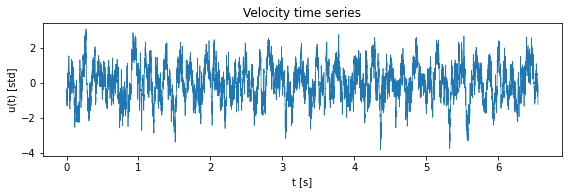

In [2]:
# Load experimental (or synthetic) data
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# Try to find experimental file; else fallback to synthetic
CANDIDATES = [Path('hotwire_like_timeseries.csv'), Path('/mnt/data/hotwire_like_timeseries.csv')]
ts_path = None
for p in CANDIDATES:
    if p.exists():
        ts_path = p; break

if ts_path is not None:
    ts = pd.read_csv(ts_path)
    t = ts['t_s'].to_numpy()
    u = ts['u_std'].to_numpy()
    source = f'Loaded: {ts_path}'
else:
    rng = np.random.default_rng(2028)
    # synthetic with approximate k^{-5/3} temporal slope between cutoffs
    n, dt = 2**15, 2e-4
    t = np.arange(n)*dt
    f = np.fft.rfftfreq(n, d=dt)
    w = 2*np.pi*f
    amp = (w+1e-9)**(-5/6)          # |U| ~ w^{-5/6} => PSD ~ w^{-5/3}
    amp *= 1.0 - np.exp(-(w/(2*np.pi*3+1e-9))**2)
    amp *= np.exp(-(w/(2*np.pi*1200+1e-9))**2)
    amp[0] = 0.0
    phi = rng.uniform(0, 2*np.pi, size=amp.size)
    Uk = amp*np.exp(1j*phi)
    u = np.fft.irfft(Uk, n=t.size)
    u = (u - u.mean())/(u.std()+1e-12)
    source = 'Synthetic (in‑notebook)'
    
print(source, f' | samples={u.size}, dt={t[1]-t[0]:.3e}s')
plt.figure(figsize=(8,2.8)); plt.plot(t, u, lw=0.7)
plt.xlabel('t [s]'); plt.ylabel('u(t) [std]'); plt.title('Velocity time series')
plt.tight_layout(); plt.show()


## 8.2 Energy Spectrum and −5/3 Law

We compute the one‑sided PSD of \(u(t)\) and, with \(k=2\pi f/U_\infty\), obtain \(E(k)\). We overlay a \(-5/3\) reference slope over the apparent inertial range.


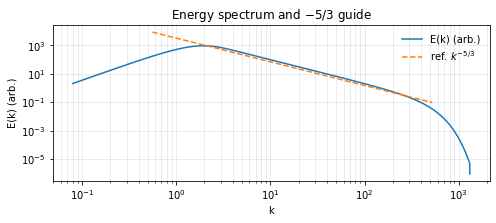

In [21]:
import numpy as np, matplotlib.pyplot as plt

U_inf = 12.0  # m/s (edit if you have a measured mean speed)

# PSD
dt = t[1]-t[0]
Uhat = np.fft.rfft(u - u.mean())
f = np.fft.rfftfreq(u.size, d=dt)
E_f = (np.abs(Uhat)**2) * (2.0/u.size)  # proportional PSD

# Map to wavenumber
k = 2*np.pi*f/ max(U_inf, 1e-9)
E_k = E_f * (U_inf/(2*np.pi))           # proportional mapping

# Plot
plt.figure(figsize=(7,3.2))
mask = (f>1.0) & (f<1000.0)  # a broad band for visualization
plt.loglog(k[1:], E_k[1:], label='E(k) (arb.)')

# -5/3 reference line anchored at a middle k
mid = np.where(mask)[0]
if mid.size>0:
    iref = mid[mid.size//2]
    C = E_k[iref]*(k[iref]**(5/3))
    plt.loglog(k[mask], C*(k[mask]**(-5/3)), '--', label='ref. $k^{-5/3}$')

plt.xlabel('k'); plt.ylabel('E(k) (arb.)')
plt.title('Energy spectrum and $-5/3$ guide')
plt.grid(True, which='both', alpha=0.3); plt.legend(frameon=False)
plt.tight_layout(); plt.show()


## 8.3. Structure Functions: 2nd and 3rd Order

We estimate longitudinal increments via time lags and then map to spatial separations using \( r=U_\infty\,\tau \):

- \( S_2(r) = \langle [\delta u_L(r)]^2 \rangle \)  
- \( S_3(r) = \langle [\delta u_L(r)]^3 \rangle \)  (used with the 4/5 law)

For well‑developed inertial ranges, \( S_2 \sim r^{2/3} \) and \( S_3 \sim -\varepsilon r \).


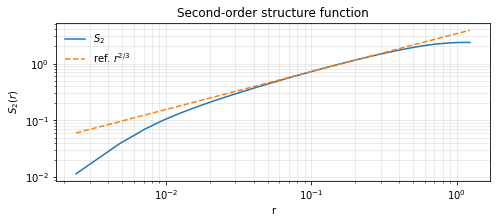

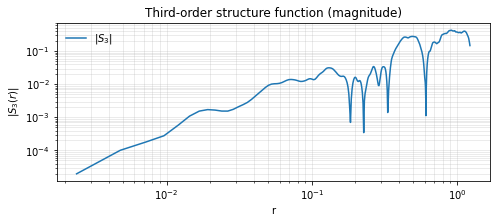

In [8]:
import numpy as np, matplotlib.pyplot as plt

def strf(u, max_lag):
    N = u.size
    S2 = np.empty(max_lag); S3 = np.empty(max_lag)
    for m in range(1, max_lag+1):
        du = u[m:] - u[:-m]
        S2[m-1] = np.mean(du*du)
        S3[m-1] = np.mean(du*du*du)
    return S2, S3

max_lag = u.size//64
S2, S3 = strf(u, max_lag=max_lag)
lags = np.arange(1, max_lag+1)
tau = lags * dt
r = U_inf * tau

plt.figure(figsize=(7,3.2))
plt.loglog(r, S2, label=r'$S_2$')
# r^{2/3} guide
iref = max_lag//6
C2 = S2[iref]/(r[iref]**(2/3)+1e-20)
plt.loglog(r, C2*r**(2/3), '--', label='ref. $r^{2/3}$')
plt.xlabel('r'); plt.ylabel(r'$S_2(r)$')
plt.title('Second‑order structure function')
plt.grid(True, which='both', alpha=0.3); plt.legend(frameon=False)
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.2))
plt.loglog(r, np.abs(S3), label=r'$|S_3|$')
plt.xlabel('r'); plt.ylabel(r'$|S_3(r)|$')
plt.title('Third‑order structure function (magnitude)')
plt.grid(True, which='both', alpha=0.3); plt.legend(frameon=False)
plt.tight_layout(); plt.show()


## 8.4. Estimate Dissipation from 4/5 Law

Using the **Kolmogorov 4/5 law** for the third‑order longitudinal structure function,
\( S_3(r) = \langle [\delta u_L]^3 \rangle = -\tfrac{4}{5}\,\varepsilon\, r \),
we estimate \( \varepsilon \) from the **best linear fit** of \(S_3\) vs \(r\) over a user‑selected band presumed to lie inside the inertial range.


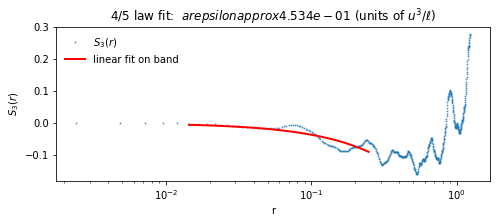

In [22]:
import numpy as np, matplotlib.pyplot as plt

# choose a band for fitting (adjust ranges as needed based on spectrum)
rmin, rmax = r[int(0.01*len(r))], r[int(0.2*len(r))]
mask = (r>=rmin) & (r<=rmax)

# linear fit S3 = a + b r; expect a≈0 and b≈ -(4/5) ε
A = np.vstack([np.ones_like(r[mask]), r[mask]]).T
a,b = np.linalg.lstsq(A, S3[mask], rcond=None)[0]
eps_est = - (5.0/4.0) * b

plt.figure(figsize=(7,3.2))
plt.plot(r, S3, '.', ms=2, alpha=0.6, label=r'$S_3(r)$')
plt.plot(r[mask], (a + b*r[mask]), 'r-', lw=2, label='linear fit on band')
plt.xscale('log')
plt.xlabel('r'); plt.ylabel(r'$S_3(r)$')
plt.title(fr'4/5 law fit:  $arepsilon approx {eps_est:.3e}$ (units of $u^3/\ell$)')
plt.legend(frameon=False); plt.tight_layout(); plt.show()


## 8.5 Spectral Collapse and Scaling

$$\text{We normalize the spectrum with the dissipation estimate to expose the inertial‑range plateau:plot}  E(k),\varepsilon^{-2/3} k^{5/3} versus k. \text{A flat region indicates -5/3 scaling$$.



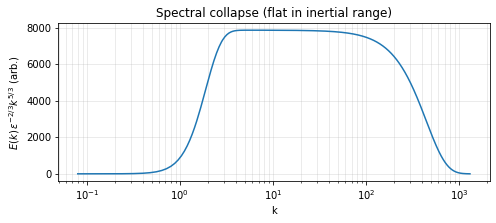

In [27]:
import numpy as np, matplotlib.pyplot as plt

eps = float(eps_est) if np.isfinite(eps_est) else 1.0
E_c = E_k * (eps**(-2/3)) * (k**(5/3))
plt.figure(figsize=(7,3.2))
plt.semilogx(k[1:], E_c[1:])
plt.xlabel('k'); plt.ylabel(r'$E(k)\,\varepsilon^{-2/3}k^{5/3}$ (arb.)')
plt.title('Spectral collapse (flat in inertial range)')
plt.grid(True, which='both', alpha=0.3); plt.tight_layout(); plt.show()


## Summary

- The notebook reproduces the chapter’s central results: \(-5/3\) spectral scaling, \(S_2 \sim r^{2/3}\), and the **4/5 law** for \(S_3\).
- Taylor’s hypothesis converts single‑point time series into spatial statistics usable for spectra and structure functions.
- A dissipation estimate from \(S_3\) enables **spectral collapse** plots that sharpen the inertial‑range plateau.
- Code paths accept real CSV data when available, falling back to synthetic data with similar statistics.


# 8.6:  Plotting Karman-Howarth Balance Equation

## Kármán–Howarth Equation in Homogeneous Isotropic Turbulence

This notebook analyzes turbulence statistics through structure functions and spectra, and connects them to the Kármán–Howarth equation — a cornerstone of isotropic turbulence theory. The data used may be synthetic or experimental.

### What Is Being Plotted and Why

---

#### Step 1: **Velocity Time Series**

The raw velocity signal \( u(t) \) is plotted. This may come from:
- Synthetic generation (with approximate \( k^{-5/3} \) energy scaling), or
- Experimental data (e.g., hot-wire time series).

**Purpose:** To verify stationarity and visualize turbulence intensity in time.

---

#### Step 2. **Energy Spectrum \( E(k) \)**

The time signal is converted to wavenumber space via FFT and mapped using Taylor’s hypothesis:

$$
E(k) \propto | \hat{u}(k) |^2
$$

A guide slope of \( k^{-5/3} \) is shown for comparison.

**Purpose:** To verify the inertial range scaling and spectral content.

---

#### Step 3. **Second-Order Structure Function \( S_2(r) \)**

Defined as:

$$
S_2(r) = \left\langle [u(x + r) - u(x)]^2 \right\rangle
$$

In the inertial range, Kolmogorov 1941 (K41) theory predicts:

$$
S_2(r) = C_2 (\varepsilon r)^{2/3}
$$

**Purpose:** To confirm the \( r^{2/3} \) scaling in the inertial range.

---

#### Step 4. **Third-Order Structure Function \( S_3(r) \)**

Defined as:

$$
S_3(r) = \left\langle [u(x + r) - u(x)]^3 \right\rangle
$$

Kolmogorov’s exact four-fifths law (for high Reynolds number and isotropic turbulence):

$$
S_3(r) = -\frac{4}{5} \varepsilon r
$$

The plot typically shows \( |S_3(r)| \) vs. \( r \) on log-log axes.

**Purpose:** To examine whether the data satisfy the linear scaling predicted by the four-fifths law.

---

#### 5. **Two-Point Velocity Correlation Function \( F(r) \)**

The two-point (longitudinal) velocity correlation is defined as:

$$
F(r) = \left\langle u(x) u(x + r) \right\rangle
$$

This quantity measures how strongly velocity fluctuations at two points separated by a distance \( r \) are correlated. It starts at \( F(0) = \langle u^2 \rangle \) and decays toward zero as \( r \to \infty \), reflecting the loss of coherence at larger separations.

**In isotropic turbulence**, the function is:
- Even in \( r \),
- Related to the second-order structure function via:
  
  $$
  S_2(r) = 2 \left[ F(0) - F(r) \right]
  $$

A typical plot shows \( F(r) \) vs. \( r \), either in linear or semilog scale, and demonstrates the scale of spatial coherence.

**Purpose:**  
To visualize how quickly velocity fluctuations decorrelate across space, and to estimate the integral length scale:

$$
L = \int_0^\infty \frac{F(r)}{F(0)} \, dr
$$

which characterizes the energy-containing eddy size.


#### Step 6. **Kármán–Howarth Residue**

We numerically compute the residue of the stationary Kármán–Howarth equation (neglecting time evolution), given by:

$$
R(r) = \frac{d}{dr} \left( \frac{S_3(r)}{r} \right)
$$

For high-Reynolds-number turbulence:

$$
R(r) \approx -6 \nu \frac{d^2 S_2(r)}{dr^2}
$$

At inertial scales (away from dissipation and forcing), the viscous term on the right-hand side is negligible, so \( R(r) \to 0 \).

**Purpose:** To test whether the empirical structure functions satisfy the stationary Kármán–Howarth balance. The residue highlights departures due to viscous or finite-Reynolds effects.

---

### Summary

These plots together provide a full diagnostic of turbulent behavior:

- **Spectrum:** Reveals inertial and dissipative ranges.
- **Structure functions:** Capture velocity differences across scales.
- **Four-fifths law:** Validates Kolmogorov's exact result.
- **Kármán–Howarth residue:** Tests energy balance across scales.

They form a powerful framework for interpreting both DNS and lab turbulence datasets.


Synthetic surrogate | N=32768, dt=2.000e-04s, U_inf=12.0 m/s, nu=1.50e-05 m^2/s


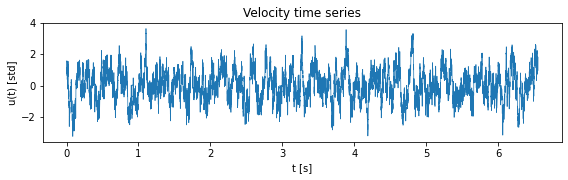

In [24]:
# STEP1: 8.6 --- Setup and data ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Choose: load experimental CSV OR synthesize
CSV = None  # e.g., Path("hotwire_like_timeseries.csv")
U_inf = 12.0       # m/s mean convection speed (edit for your flow)
nu   = 1.5e-5      # m^2/s kinematic viscosity (air ~1.5e-5 at STP)

if CSV and Path(CSV).exists():
    import pandas as pd
    df = pd.read_csv(CSV)
    t = df["t_s"].to_numpy()
    u = df["u_std"].to_numpy()
    src = f"Loaded {CSV}"
else:
    # Synthetic surrogate with ~ f^{-5/3} PSD band
    rng = np.random.default_rng(2028)
    n, dt = 2**15, 2e-4
    t = np.arange(n)*dt
    f = np.fft.rfftfreq(n, d=dt)
    w = 2*np.pi*f
    amp = (w+1e-9)**(-5/6)
    amp *= 1.0 - np.exp(-(w/(2*np.pi*3+1e-9))**2)      # low-f cutoff
    amp *= np.exp(-(w/(2*np.pi*1200+1e-9))**2)         # high-f cutoff
    amp[0] = 0.0
    phi = rng.uniform(0, 2*np.pi, size=amp.size)
    Uk  = amp*np.exp(1j*phi)
    u   = np.fft.irfft(Uk, n=t.size)
    u   = (u - u.mean())/(u.std()+1e-12)
    src = "Synthetic surrogate"
print(src, f"| N={u.size}, dt={t[1]-t[0]:.3e}s, U_inf={U_inf} m/s, nu={nu:.2e} m^2/s")

plt.figure(figsize=(8,2.6)); plt.plot(t, u, lw=0.7)
plt.xlabel("t [s]"); plt.ylabel("u(t) [std]"); plt.title("Velocity time series")
plt.tight_layout(); plt.show()


eps_hat from 4/5-law fit ≈ 2.263e-01 (units of m^2/s^3)


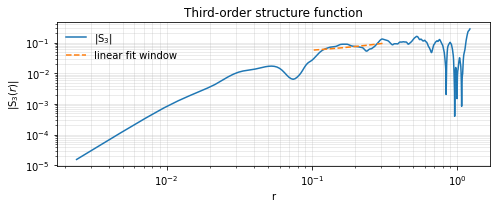

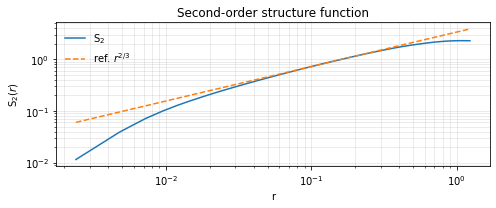

In [25]:
# Step 2, Step 3 --- Structure functions and eps estimate from 4/5-law ---
def structure_functions(u, max_lag):
    S2 = np.empty(max_lag); S3 = np.empty(max_lag)
    for m in range(1, max_lag+1):
        du = u[m:] - u[:-m]
        S2[m-1] = np.mean(du*du)
        S3[m-1] = np.mean(du*du*du)
    return S2, S3

dt = t[1]-t[0]
max_lag = u.size//64
S2, S3 = structure_functions(u, max_lag)
lags = np.arange(1, max_lag+1)
tau  = lags*dt
r    = U_inf*tau  # Taylor mapping

# Simple linear fit for S3 ~ -(4/5) eps r over a mid-window
i0, i1 = max_lag//12, max_lag//4   # adjust if needed
A = np.vstack([r[i0:i1], np.ones_like(r[i0:i1])]).T
a, b = np.linalg.lstsq(A, S3[i0:i1], rcond=None)[0]  # S3 = a r + b
eps_hat = -(5.0/4.0)*a

print(f"eps_hat from 4/5-law fit ≈ {eps_hat:.3e} (units of m^2/s^3)")

plt.figure(figsize=(7,3))
plt.loglog(r, np.abs(S3), label=r"|S$_3$|")
plt.loglog(r[i0:i1], np.abs(a*r[i0:i1]+b), "--", label="linear fit window")
plt.xlabel("r"); plt.ylabel(r"|S$_3(r)$|")
plt.title("Third-order structure function")
plt.legend(frameon=False); plt.grid(True, which="both", alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3))
plt.loglog(r, S2, label=r"S$_2$")
C2 = S2[i0]/(r[i0]**(2/3)+1e-30)
plt.loglog(r, C2*r**(2/3), "--", label=r"ref. $r^{2/3}$")
plt.xlabel("r"); plt.ylabel(r"S$_2(r)$")
plt.title("Second-order structure function")
plt.legend(frameon=False); plt.grid(True, which="both", alpha=0.3); plt.tight_layout(); plt.show()


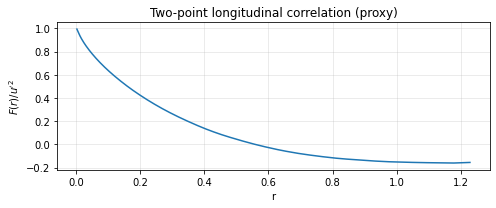

In [15]:
# Step 4 --- Two-point longitudinal correlation F(r) via autocorrelation ---
# Unbiased autocorrelation for lags up to max_lag
u0 = u - u.mean()
var = np.mean(u0*u0)

F = np.empty(max_lag)
for m in range(1, max_lag+1):
    x = u0[:-m]; y = u0[m:]
    F[m-1] = np.mean(x*y)

# Optional normalization to single-point variance u'^2
u_rms2 = var
F_L = F  # longitudinal proxy from 1D traverse

plt.figure(figsize=(7,3))
plt.plot(r, F_L/u_rms2)
plt.xlabel("r"); plt.ylabel(r"$F(r)/u'^2$")
plt.title("Two-point longitudinal correlation")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


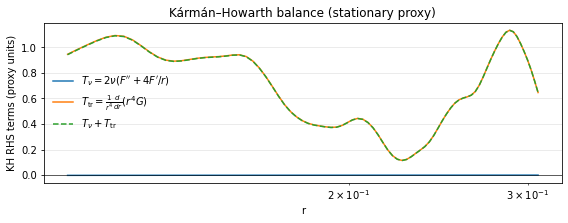

In [26]:
#Step 5 --- KH balance terms ---
# Smooth numeric derivatives (Savitzky–Golay helps reduce noise)
from scipy.signal import savgol_filter

# Smooth F(r) and G(r) before differentiation
G = -S3/3.0

# Choose an inertial-ish window for derivatives to avoid edges
win = max(7, (max_lag//50)*2+1)   # odd window length
if win >= len(r): win = len(r)-(1-(len(r)%2))  # ensure odd < len

F_s = savgol_filter(F_L, window_length=win, polyorder=3, mode="interp")
G_s = savgol_filter(G,   window_length=win, polyorder=3, mode="interp")

# Derivatives w.r.t r
dr = np.gradient(r)
F_r  = np.gradient(F_s, r, edge_order=2)
F_rr = np.gradient(F_r, r, edge_order=2)

# Viscous term: 2 nu (F'' + 4 F'/r)
with np.errstate(divide='ignore', invalid='ignore'):
    T_nu = 2.0*nu*(F_rr + 4.0*F_r/np.maximum(r, 1e-30))

# Transfer term: (1/r^4) d/dr ( r^4 G )
r4G  = (r**4)*G_s
d_r4G = np.gradient(r4G, r, edge_order=2)
with np.errstate(divide='ignore', invalid='ignore'):
    T_tr = d_r4G / np.maximum(r**4, 1e-30)

# Mask a safe window (avoid tiny r and very large r)
mask = (r > r[i0]) & (r < r[i1])

plt.figure(figsize=(8,3.2))
plt.semilogx(r[mask], T_nu[mask], label=r"$T_\nu=2\nu(F''+4F'/r)$")
plt.semilogx(r[mask], T_tr[mask], label=r"$T_{\rm tr}=\frac{1}{r^4}\frac{d}{dr}(r^4 G)$")
plt.semilogx(r[mask], (T_nu+T_tr)[mask], '--', label=r"$T_\nu+T_{\rm tr}$")
plt.axhline(0, color='k', lw=0.6)
plt.xlabel("r"); plt.ylabel("KH RHS terms (proxy units)")
plt.title("Kármán–Howarth balance (stationary proxy)")
plt.legend(frameon=False); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


print(
"""Expectations in a reasonable inertial window:
- S3(r) ~ -(4/5) eps r   (linear, negative; eps from slope)
- S2(r) ~ r^{2/3}        (parallel to reference guide)
- KH RHS ~ 0: T_nu ~ 0 at moderate r, and T_nu + T_tr ~ 0 overall
Caveats:
- Very small r: differentiation amplifies noise (regularize with smoothing).
- Large r: finite-record, anisotropy, and Taylor's mapping errors.
- If you have 3D velocity fields, use true longitudinal components and shells; this 1D traverse is a proxy."""
)
